# STA 201 Final

## Export Configurations

In [1]:
import subprocess

def run_command(command):
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    return result.stdout

# Gather system information
report = "### System Configuration Report\n\n"
report += "**CPU Information:**\n" + run_command("lscpu") + "\n"
report += "**GPU Information:**\n" + run_command("nvidia-smi") + "\n"
report += "**Memory Information:**\n" + run_command("free -h") + "\n"
report += "**Disk Space:**\n" + run_command("df -h") + "\n"
report += "**Python Version:**\n" + run_command("python --version") + "\n"

print(report)

!pip list > requirements.txt

### System Configuration Report

**CPU Information:**
Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               2
On-line CPU(s) list:                  0,1
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
CPU family:                           6
Model:                                79
Thread(s) per core:                   2
Core(s) per socket:                   1
Socket(s):                            1
Stepping:                             0
BogoMIPS:                             4400.35
Flags:                                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known

## Dependencies

In [2]:
!pip install stargazer
import pandas as pd
import numpy as np
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

## Load Dataset

In [3]:
# URL of the dataset
url = 'https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv'

# Load the dataset into a pandas DataFrame
df = pd.read_csv(url)

# Filter data for China only
china_emission_data = df[df['country'] == 'China'][['year', 'co2']]

# Drop rows with missing CO2 data
china_emission_data = china_emission_data.dropna()

# Display the first few rows of the data
print(china_emission_data)

      year        co2
9769  1907     19.894
9770  1908     22.736
9771  1909     24.252
9772  1910     25.009
9773  1911     24.631
...    ...        ...
9881  2019  10713.984
9882  2020  10905.693
9883  2021  11447.913
9884  2022  11350.538
9885  2023  11902.503

[117 rows x 2 columns]


      year        co2  D
9860  1998   3364.587  0
9861  1999   3557.275  0
9862  2000   3649.227  0
9863  2001   3728.510  0
9864  2002   4103.046  0
9865  2003   4841.119  0
9866  2004   5217.351  0
9867  2005   5882.106  0
9868  2006   6494.331  0
9869  2007   6983.547  0
9870  2008   7501.498  0
9871  2009   7891.078  0
9872  2010   8620.576  0
9873  2011   9532.332  1
9874  2012   9779.292  1
9875  2013   9956.329  1
9876  2014   9990.257  1
9877  2015   9863.457  1
9878  2016   9762.714  1
9879  2017  10006.343  1
9880  2018  10332.992  1
9881  2019  10713.984  1
9882  2020  10905.693  1
9883  2021  11447.913  1
9884  2022  11350.538  1
9885  2023  11902.503  1


<ipython-input-4-c719adeafab8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


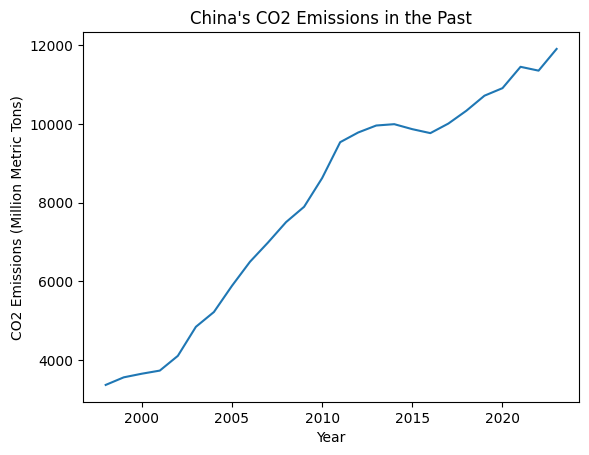

In [4]:
import matplotlib.pyplot as plt
recent_years = china_emission_data[china_emission_data['year'] >= 2023 - 25]

recent_years['D'] = 0
recent_years.loc[recent_years.year>=2011, 'D'] = 1

# Display the first few rows of the filtered data
print(recent_years)

# Plot the data
plt.plot(recent_years["year"], recent_years["co2"])
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Million Metric Tons)")
plt.title("China's CO2 Emissions in the Past")
plt.show()

## Regression Discontinuity Analysis

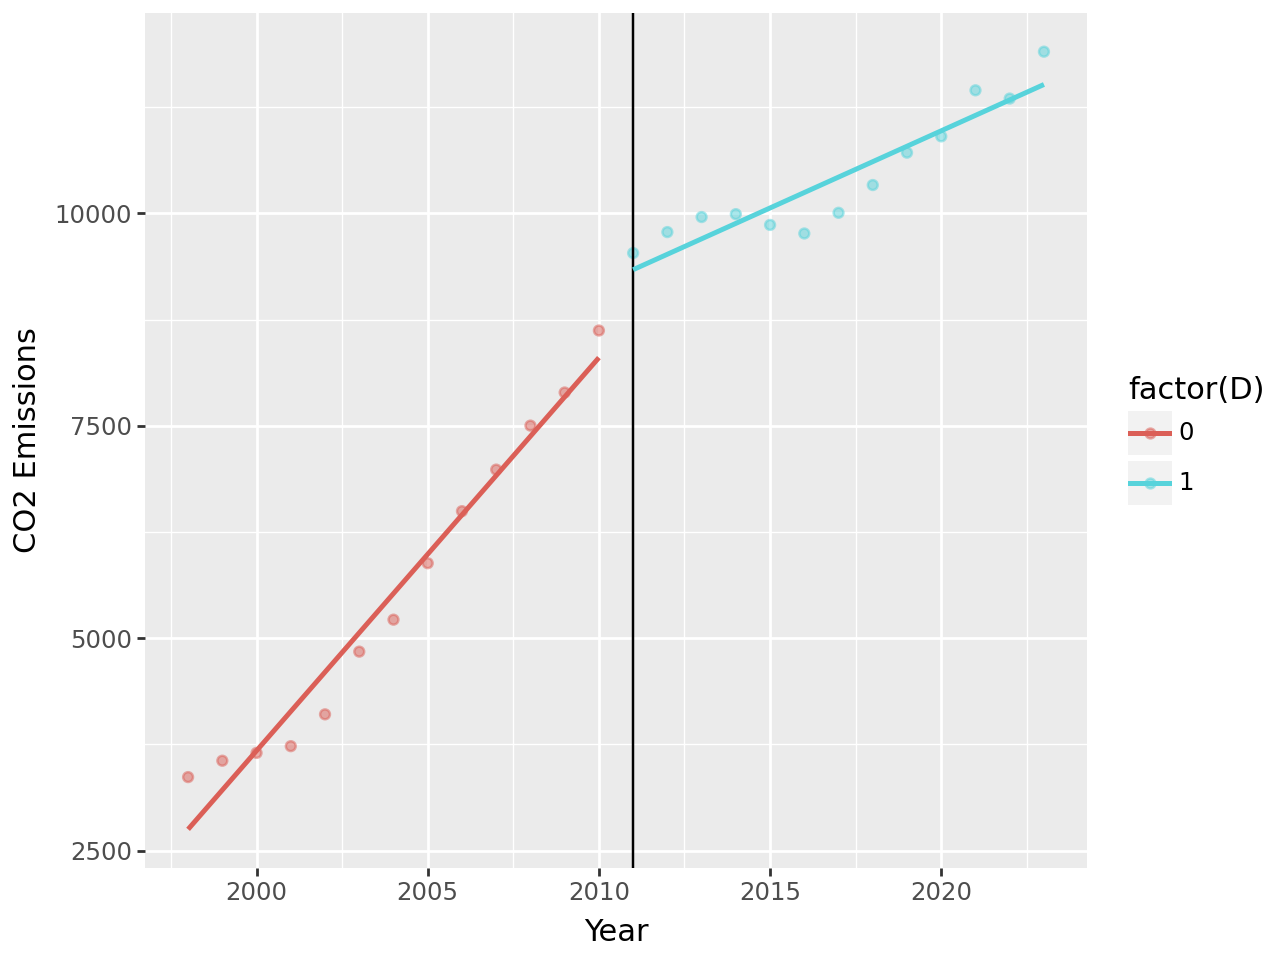

In [5]:
p.ggplot(recent_years, p.aes(x='year', y='co2', color='factor(D)')) +\
    p.geom_point(alpha=0.5) +\
    p.geom_vline(xintercept=2011, colour="black") +\
    p.stat_smooth(method="lm", se=False) +\
    p.labs(x="Year", y="CO2 Emissions") +\
    p.xlim(1998, 2023)  # Set the desired x-axis limits

In [6]:
# Fully interacted regression
all_columns = "+".join(recent_years.columns.difference(["D", 'co2']))
formula = 'co2 ~ D * ({})'.format(all_columns)

regression = sm.OLS.from_formula(formula, data = recent_years).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     685.9
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           7.15e-22
Time:                        07:00:12   Log-Likelihood:                -184.09
No. Observations:                  26   AIC:                             376.2
Df Residuals:                      22   BIC:                             381.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.216e+05   4.64e+04    -19.847      0.000   -1.02e+06   -8.25e+05
D           5.657e+05   6.59e+04      8.586      0.000    4.29e+05    7.02e+05
year         462.6522     23.172     19.966      0.000     414.597     510.707
D:year      -280.9971     32.770     -8.575      0.000    -348.957    -213.037
==============================================================================
Omnibus:                        0.528   Durbin-Watson:                   0.566
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.599
Skew:                          -0.022   Prob(JB):                        0.741
Kurtosis:                       2.258   Cond. No.                     2.83e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""